### References:
- Article: https://analyticsindiamag.com/a-beginners-guide-to-time-series-modelling-using-pycaret/
- Code: https://colab.research.google.com/drive/1eQslDiNAHNj_7i5aayUF1RFjVdXeuuKl?usp=sharing

In [1]:
# !pip install pycaret[full]

In [14]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from pycaret.regression import *

In [3]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
test_df = pd.read_csv('test.csv', parse_dates=['date'])

ID = 'row_id'
TARGET = 'num_sold'

dfs_dict = {"train":train_df, "test":test_df}
test_ids = test_df['row_id']

In [4]:
baseline_pred = []
num_sold_mean = int(train_df[TARGET].mean())
for id in test_ids:
    baseline_pred.append((id, num_sold_mean))

In [5]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [6]:
# Not sure if this is strictly necessary but seems logical to separate the data for each of the country / store / combo => 18 series
data_repo = {}
train_df['key'] = train_df['country'] + '_' + train_df['store'] + '_' + train_df['product']
for key in train_df['key'].unique():
    data_repo[key] = train_df[train_df['key'] == key].copy()

In [27]:
def train_product(prodkey):
    data = data_repo[prodkey]

    #Drop unneeded columns:
    data = data.drop(['country', 'store', 'product', 'key', 'row_id'], axis=1)
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values('date')
    data['month'] = [i.month for i in data['date']]
    data['year'] = [i.year for i in data['date']]
    data['day_of_week'] = [i.dayofweek for i in data['date']]
    data['day_of_year'] = [i.dayofyear for i in data['date']]
    
    # initialize setup
    train = data[data['year'] < 2018]
    test = data[data['year'] >= 2018]
    Setup_ = setup(data = train, test_data = test, target = 'num_sold', fold_strategy = 'timeseries', numeric_features = ['year','month','day_of_week','day_of_year'], fold = 3, transform_target = True, session_id = 123, silent=True)
    # best = compare_models(sort = 'MAE')
    # Try MSE too
    best = compare_models(sort = 'MSE')
    final_best = finalize_model(best)
    # prediction_holdout = predict_model(best)
    future_dates = pd.date_range(start = '2019-01-01', end = '2019-12-31', freq = 'D')
    future_df = pd.DataFrame()
    future_df['month'] = [i.month for i in future_dates]
    future_df['year'] = [i.year for i in future_dates] 
    future_df['day_of_week'] = [i.dayofweek for i in future_dates]
    future_df['day_of_year'] = [i.dayofyear for i in future_dates]
    future_df['date'] = future_dates
    predictions_future = predict_model(final_best, data=future_df)
    return predictions_future




In [28]:
forecastrepo = {}
for key in train_df['key'].unique():
    forecastrepo[key] = train_product(key)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,17.2895,839.0365,28.2478,0.5347,0.1160,0.0764,0.0167
rf,Random Forest Regressor,16.3085,910.1470,29.5928,0.5012,0.1125,0.0703,0.1933
xgboost,Extreme Gradient Boosting,18.4762,1064.2353,32.2790,0.4266,0.1225,0.0798,0.0567
gbr,Gradient Boosting Regressor,17.0667,1091.6340,32.6487,0.3789,0.1161,0.0735,0.0433
catboost,CatBoost Regressor,18.9807,1209.5180,34.5711,0.3523,0.1285,0.0823,1.0433
knn,K Neighbors Regressor,24.0844,1265.5976,34.9733,0.3123,0.1508,0.1045,0.0500
ada,AdaBoost Regressor,17.1070,1291.6322,35.5739,0.3213,0.1276,0.0705,0.0333
lightgbm,Light Gradient Boosting Machine,17.8458,1404.7628,37.3774,0.2469,0.1352,0.0734,0.0333
et,Extra Trees Regressor,19.0674,1432.7663,37.7237,0.2372,0.1389,0.0814,0.1633
br,Bayesian Ridge,17.2385,1471.5248,38.2448,0.2128,0.1376,0.0696,0.0133


Generating chart for:  Finland_KaggleMart_Kaggle Mug
Generating chart for:  Finland_KaggleMart_Kaggle Hat
Generating chart for:  Finland_KaggleMart_Kaggle Sticker
Generating chart for:  Finland_KaggleRama_Kaggle Mug
Generating chart for:  Finland_KaggleRama_Kaggle Hat
Generating chart for:  Finland_KaggleRama_Kaggle Sticker
Generating chart for:  Norway_KaggleMart_Kaggle Mug
Generating chart for:  Norway_KaggleMart_Kaggle Hat
Generating chart for:  Norway_KaggleMart_Kaggle Sticker
Generating chart for:  Norway_KaggleRama_Kaggle Mug
Generating chart for:  Norway_KaggleRama_Kaggle Hat
Generating chart for:  Norway_KaggleRama_Kaggle Sticker
Generating chart for:  Sweden_KaggleMart_Kaggle Mug
Generating chart for:  Sweden_KaggleMart_Kaggle Hat
Generating chart for:  Sweden_KaggleMart_Kaggle Sticker
Generating chart for:  Sweden_KaggleRama_Kaggle Mug
Generating chart for:  Sweden_KaggleRama_Kaggle Hat
Generating chart for:  Sweden_KaggleRama_Kaggle Sticker


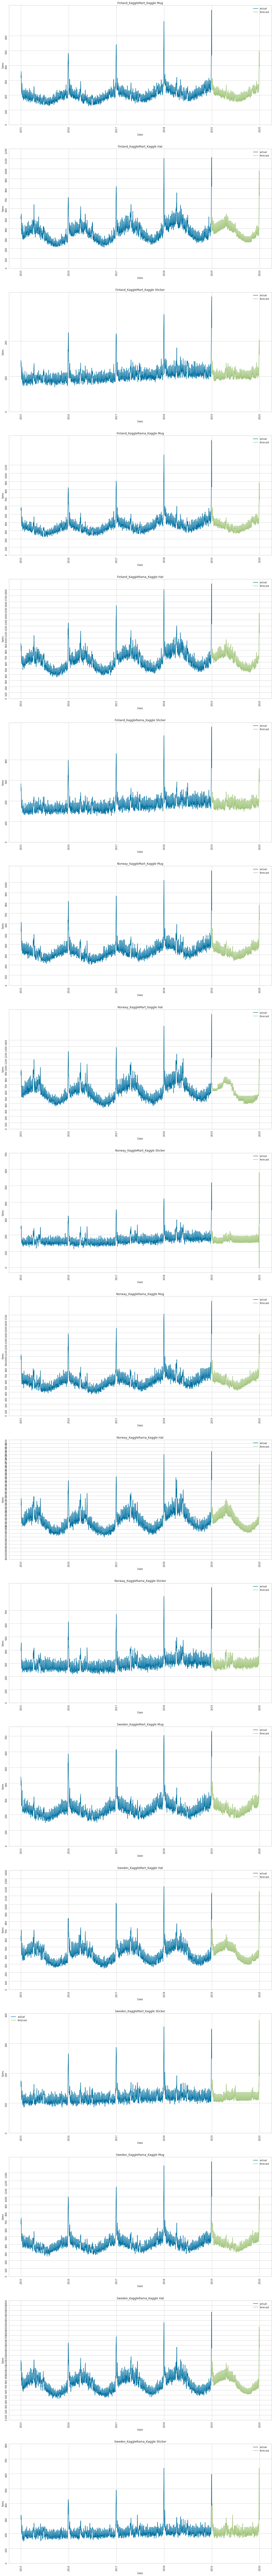

In [29]:
compSubResultDict = forecastrepo
rowCount = len(list(compSubResultDict.keys()))

fig, axs = plt.subplots(rowCount, figsize=(20,200))
    # fig.subplots_adjust(hspace=0.4,wspace=0.2)
i = 0
for currProd in list(compSubResultDict.keys()):
    print("Generating chart for: ", currProd)
    forecast = forecastrepo[currProd]
    data = data_repo[currProd]
        
    concat_df = pd.concat([data,forecast], axis=0)
    data['date'] = pd.to_datetime(data['date'])
    # df_compareError = forecast[['ds', 'yhat']]
    # df_compareError = pd.concat([df_compareError, df_pivot[[currProd]].reset_index()], axis=1)
    # df_compareError['date'] = pd.to_datetime(df_compareError['date'])
    # df_compareError.plot(x='date', y=[currProd, 'yhat'], kind='line', figsize=(15,8))
    axs[i].plot(data['date'], data['num_sold'], label="actual")
    axs[i].plot(concat_df['date'], concat_df['Label'], label="forecast")
    axs[i].tick_params(labelrotation=90)
    axs[i].set_xlabel("Date", fontsize=10)
    axs[i].set_ylabel("Sales", fontsize=10)                         
    axs[i].set_yticks(np.arange(0,concat_df['Label'].max()*1.3,100))
    axs[i].legend()
    axs[i].set_title(currProd)        

            # actual_df = df_pivot[countryList[j] + '_' + store + '_' + productList[i]                             
            # axs[i, j].plot(df["ID"],df["Column A"], label = "Stuff")
            # axs[i, j].tick_params(labelrotation=90)
            # 
            # axs[i, j].set_xticks(np.arange(0,26,1))
            # 
            # axs[i, j].grid(color='gray', linestyle='-', linewidth=0.3)
    i += 1

plt.show()

### Generating Submission results

In [30]:
test_df = pd.read_csv('test.csv')
test_df.head()

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [31]:
key = 'Finland_KaggleMart_Kaggle Hat'
compSubResultDict[key]['date'].min()

Timestamp('2019-01-01 00:00:00')

In [32]:
finalResult = pd.DataFrame()
for key in list(compSubResultDict.keys()):

#     key = 'Finland_KaggleMart_Kaggle Hat'
    print(key)
    country = key.split('_')[0]
    store = key.split('_')[1]
    product = key.split('_')[2]
    curr_test_df = test_df[(test_df['country'] == country) & 
                           (test_df['store'] == store) & 
                           (test_df['product'] == product)].copy()
    # print('Curr_test_df shape', curr_test_df.shape)
    curr_test_df = curr_test_df.sort_values('date')
    # print(curr_test_df.head())
    predResult = compSubResultDict[key]['Label']
    # print(predResult.head())
    # print(predResult.tail())
    # print(len(predResult.values))
    # print(compSubResultDict[key][['ds','yhat']][-365:]).tail()
    # print('predResult shape', predResult.shape)
    # print('predResult null shape', len(predResult[predResult.isnull()]))
    curr_test_df['num_sold'] = predResult.values
    # print('Prediction shape', compSubResultDict[key].shape)
    # print('Prediction min date', compSubResultDict[key]['ds'].min())
    # print('Prediction max date', compSubResultDict[key]['ds'].max())

    finalResult = finalResult.append(curr_test_df)
    # print('finalResult shape', finalResult.shape)
    # print('curr_test_df null shape', curr_test_df[curr_test_df['num_sold'].isnull()].shape)

Finland_KaggleMart_Kaggle Mug
Finland_KaggleMart_Kaggle Hat
Finland_KaggleMart_Kaggle Sticker
Finland_KaggleRama_Kaggle Mug
Finland_KaggleRama_Kaggle Hat
Finland_KaggleRama_Kaggle Sticker
Norway_KaggleMart_Kaggle Mug
Norway_KaggleMart_Kaggle Hat
Norway_KaggleMart_Kaggle Sticker
Norway_KaggleRama_Kaggle Mug
Norway_KaggleRama_Kaggle Hat
Norway_KaggleRama_Kaggle Sticker
Sweden_KaggleMart_Kaggle Mug
Sweden_KaggleMart_Kaggle Hat
Sweden_KaggleMart_Kaggle Sticker
Sweden_KaggleRama_Kaggle Mug
Sweden_KaggleRama_Kaggle Hat
Sweden_KaggleRama_Kaggle Sticker


In [33]:
finalResult.tail()

,row_id,date,country,store,product,num_sold
6497,32795,2019-12-27,Sweden,KaggleRama,Kaggle Sticker,321.0
6515,32813,2019-12-28,Sweden,KaggleRama,Kaggle Sticker,637.0
6533,32831,2019-12-29,Sweden,KaggleRama,Kaggle Sticker,637.0
6551,32849,2019-12-30,Sweden,KaggleRama,Kaggle Sticker,291.0
6569,32867,2019-12-31,Sweden,KaggleRama,Kaggle Sticker,291.0


In [34]:
finalResult = finalResult.sort_values('row_id')
finalResult['num_sold'] = finalResult['num_sold'].astype('int')
submission_df = finalResult[['row_id', 'num_sold']].to_csv('pycaret_mse_submission.csv', index=False)

/apps/python3/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/apps/python3/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/apps/python3/lib/python3.7/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations